In [403]:
import pandas as pd
import seaborn as sns
from datetime import datetime, date
import calendar
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from utils import oneHot, batch
import random
from __future__ import print_function
import tensorflow as tf
from tensorflow import reset_default_graph
import IPython.display as display
plt.rcParams['figure.figsize'] = (12, 8)
%matplotlib inline  

## read data and preprocess

In [404]:
df = pd.read_csv('cleaned_sales+weather_data.csv')
df = df.drop('Unnamed: 0' , 1)

In [405]:
df['date'] = df['date'].map( lambda x: datetime.strptime( x, '%Y-%m-%d'))
df['weekofyear'] = df['date'].dt.weekofyear
df['month'] = df['date'].dt.month
df['weekday'] = df['date'].dt.weekday
df['dayofyear'] = df['date'].dt.dayofyear
df['station'] = df['station'].map( int )
df['year'] = df['date'].dt.year
# filter
df = df[df['oms'] > 0 ]
df[:10]

,EAN,Produkttekst,avance,chain_store,date,oms,postal_no,store_name,store_no,volume,station,temp,wind,sun,precipitations,weekofyear,month,weekday,dayofyear,year
0,5741000116975,Royal B X-mas 6x33ds,1,DagliBrugsen,2015-01-01,31.00,2300,COOP DAGLIBR BRYDES ALLE,1043,1,618800,5.5,6.1,0,1.9,1,1,3,1,2015
1,5741000131084,Royal Export 6x33 ds,-13,DagliBrugsen,2015-01-01,100.00,2300,COOP DAGLIBR BRYDES ALLE,1043,4,618800,5.5,6.1,0,1.9,1,1,3,1,2015
2,5741000140284,ROYAL PLATINUM 6-PAK,8,DagliBrugsen,2015-01-01,39.95,2300,COOP DAGLIBR BRYDES ALLE,1043,1,618800,5.5,6.1,0,1.9,1,1,3,1,2015
3,5741000131084,Royal Export 6x33 ds,17,DagliBrugsen,2015-01-01,79.90,2400,COOP DAGLIBR BISPEPARKEN,1053,2,618800,5.5,6.1,0,1.9,1,1,3,1,2015
4,5741000132463,Royal Exp. kuffert24,-19,DagliBrugsen,2015-01-01,299.85,2650,COOP LOKALBR FJELDSTEDVEJ,1082,3,618800,5.5,6.1,0,1.9,1,1,3,1,2015
5,5741000116494,Royal Class. 6x33 ds,10,DagliBrugsen,2015-01-01,40.95,2500,COOP LOKALBR HERMAN BANGS PLAD,1134,1,618800,5.5,6.1,0,1.9,1,1,3,1,2015
6,5741000117958,Royal Plsnr 6x33 ds,10,DagliBrugsen,2015-01-01,40.95,2500,COOP LOKALBR HERMAN BANGS PLAD,1134,1,618800,5.5,6.1,0,1.9,1,1,3,1,2015
7,5741000131077,Royal Export ds,7,DagliBrugsen,2015-01-01,24.00,2500,COOP LOKALBR HERMAN BANGS PLAD,1134,2,618800,5.5,6.1,0,1.9,1,1,3,1,2015
8,5741000132463,Royal Exp. kuffert24,-13,DagliBrugsen,2015-01-01,199.90,2610,COOP DAGLIBRUGSEN ISLEV TORV,1194,2,618800,5.5,6.1,0,1.9,1,1,3,1,2015
9,5741000135013,HEINEKEN KUFFERT,-13,DagliBrugsen,2015-01-01,199.90,2610,COOP DAGLIBRUGSEN ISLEV TORV,1194,2,618800,5.5,6.1,0,1.9,1,1,3,1,2015


## aggregate

Aggregate the data per station and day

In [406]:
features = ['oms','date','temp','sun','wind','precipitations', 'dayofyear','year','month','weekday', 'station']
q = df[features]
data = q#[ (q['month'] > 3) & (q['month'] < 10 ) ] #& (q['weekday'] == 4)]
# aggregate emp	wind	sun	precipitations
agg = data.groupby(['date', 'station' ])
aggregated_data = pd.DataFrame( { 'month' :  agg['month'].first() , 'weekday' :  agg['weekday'].first(), 'oms' : agg['oms'].sum(), 'temp':agg['temp'].first() , 'sun' : agg['sun'].first(), 'wind' : agg['wind'].first(),  'precipitations' : agg['precipitations'].first()  } )
aggregated_data.reset_index(level=0, inplace=True)
aggregated_data.reset_index(level=0, inplace=True)

aggregated_data[:3]

,station,date,month,oms,precipitations,sun,temp,weekday,wind
0,603100,2015-01-01,1,22080.76,4.5,0,6.7,3,8.7
1,607200,2015-01-01,1,36691.96,1.0,0,6.8,3,5.7
2,612600,2015-01-01,1,28939.93,0.3,0,5.4,3,8.6


## normalize 

Results are really bad with it. Thus, we keep the data unormalized for now.

In [407]:
#from sklearn import preprocessing
#def normalize(X):
#    mean = np.mean(X)
#    std = np.std(X)
#    return (X - mean)/std
#aggregated_data['precipitations'] = normalize(aggregated_data['precipitations'])
#aggregated_data['oms'] = normalize(aggregated_data['oms'])
#aggregated_data['wind'] = normalize(aggregated_data['wind'])
#aggregated_data['sun'] = normalize(aggregated_data['sun'])
#aggregated_data['temp'] = normalize(aggregated_data['temp'])
#aggregated_data[:3]
#aggregated_data.describe()

## setup train and tests splits from the dataset

Keep a sparated split of data for testing

In [425]:
features = ['month','precipitations','sun','temp','wind','weekday','station']
data = aggregated_data[features]
data = oneHot(data, 'weekday')
data = oneHot(data, 'station')
data = oneHot(data, 'month')
features = data.columns.values
labels = ['oms']
X = data.as_matrix()
y = aggregated_data[labels].values
data.describe()

,precipitations,sun,temp,wind,weekday=0,weekday=1,weekday=2,weekday=3,weekday=4,weekday=5,...,month=12,month=8,month=9,month=6,month=7,month=4,month=5,month=2,month=3,month=1
count,3310.000000,3310.000000,3310.000000,3310.000000,3310.000000,3310.000000,3310.000000,3310.000000,3310.000000,3310.000000,...,3310.000000,3310.000000,3310.000000,3310.000000,3310.000000,3310.000000,3310.000000,3310.000000,3310.000000,3310.000000
mean,2.029668,4.902447,9.475498,3.890846,0.141994,0.141994,0.141994,0.143505,0.143505,0.143505,...,0.046828,0.093656,0.090634,0.090634,0.093656,0.090634,0.093656,0.086103,0.093656,0.093656
std,3.996513,4.328633,5.938170,1.882317,0.349097,0.349097,0.349097,0.350640,0.350640,0.350640,...,0.211302,0.291393,0.287132,0.287132,0.291393,0.287132,0.291393,0.280558,0.291393,0.291393
min,0.000000,0.000000,-9.300000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.900000,4.725000,2.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.100000,4.100000,9.400000,3.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.300000,7.900000,14.500000,4.900000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,37.900000,16.100000,23.700000,13.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
full_training = False
train_ratio = 0.9
L = len(y)
idx = range(L)
random.shuffle(idx)
if not full_training:
    X_train = X[ idx[ : int(0.8 * L)  ]  , : ]
    y_train = y[ idx[ : int(0.8 * L)  ] , : ]
else:
    X_train = X
    y_train = y
X_test = X[ idx[ int(0.8 * L)  : ]  , : ]
y_test = y[ idx[ int(0.8 * L)  : ] , :]

## define accuracy function

define an accuracy function 

In [418]:
def getAcc(pred,true):
    return 1 - abs(pred-true)/true

# Random Forest Regressor

This simple model gives a 85% accuracy, quite good

accuracy: 0.85149142788


/Users/valentin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


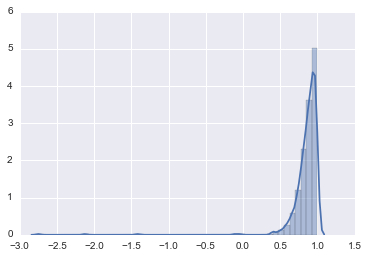

In [420]:
# define the model
rfr = RandomForestRegressor(n_estimators=200, min_samples_split=5)
# train it
rfr.fit(X_train, y_train)
# predict outputs
pred = rfr.predict(X_test)
# compute mean accuracy
scores = []
raw_scores = []
for i in range(len(pred)):
    e = getAcc(pred[i],y_test[i])
    scores.append(e)
    raw_scores.append(pred[i] / y_test[i])
print("accuracy: " + str(np.mean(scores)) )
sns.distplot(scores)

# build a non linear regressor using tensorflow

Using Tensorflow enable us to modify easily our models (to a multiclass regression problem for example)

some inspiration:
* http://stackoverflow.com/questions/34208336/tensorflow-multivariate-linear-regression-not-converging 
* http://stackoverflow.com/questions/36637901/building-a-non-linear-model-with-relus-in-tensorflow


### Here is my model: feed forward network with one hidden layer

- one layer + ReLU units
- one hidden layer + ReLU units
- output

- the cost is the Mean Squared Error (regression problem)

<img src="images/regressor_net.png">



In [421]:
tf.reset_default_graph()

# hyperparameters and graph-specific values
logs_path = '/tmp/tensorflow_logs/OiX-regressor'
epoches = 60
batch_len = 16
hidden_units = 6
learning_rate =  1e-1
n_input = X_train.shape[1]
n_output = y_train.shape[1]

# define a batch generator (stochastic gradient descent)
batch_gen = batch(X_train,y_train,batch_len)

def weight_variable(shape , name='xxx'):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial, name = name)

def bias_variable(shape, name='xxx'):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial, name = name)

# create placeholders to pass the data to the model
x = tf.placeholder('float', shape=[None, n_input], name='InputData')
y_ = tf.placeholder('float', shape=[None, n_output], name='LabelData')

# define the model
# first layer
W1 = weight_variable([n_input, hidden_units], name='W1')
b1 = bias_variable([hidden_units], name='b1')
r1 = tf.nn.relu(tf.matmul(x, W1) + b1) # non linearity
# hidden layer
W2 = weight_variable([hidden_units, n_output], name='W2')
b2 = bias_variable([n_output], name='b2')
yt =  tf.matmul(r1,W2)+b2 
ytt = tf.nn.relu(yt) # output

with tf.name_scope('Model'):
    y = ytt

# loss function: Mean Squared error
with tf.name_scope('MSE'):
    mean_square_error = tf.reduce_sum(tf.square(tf.sub(y,y_)))

# training step: gradient descent with Adam optimizer
with tf.name_scope('Optimizer'):
    training = tf.train.AdamOptimizer(learning_rate).minimize(mean_square_error)

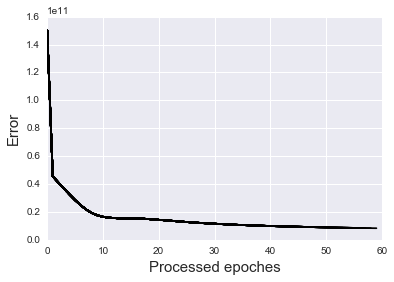

In [422]:
sess = tf.InteractiveSession()

# Create a summary to monitor cost tensor (tensorboard)
tf.scalar_summary("MSE", mean_square_error)

# merge all summaries (tensorboard)
merged_summary_op = tf.merge_all_summaries()

sess.run(tf.initialize_all_variables())
summary_writer = tf.train.SummaryWriter(logs_path, graph=tf.get_default_graph())


XX = []
YY = []
min_error = np.inf
for k in range(epoches):
    # iterrate trough every row (with batch size of 1)
    for i in range(X_train.shape[0]/batch_len):
        Xs,ys = batch_gen.getNextBatch()
        _, error, summary = sess.run([training, mean_square_error, merged_summary_op],  feed_dict={x: Xs, y_:ys})
        summary_writer.add_summary(summary, k * batch_len + i)
    
    YY.append(error)
    XX.append(k)
    plt.plot(XX, YY, 'black')
    plt.ylabel('Error', fontsize=15)
    plt.xlabel('Processed epoches', fontsize=15)
    plt.title('', fontsize=20)
    plt.grid('on')
    plt.savefig("out.png")
    display.display(display.Image(filename="out.png"))
    display.clear_output(wait=True)

MSE: 4.77407e+11
accuracy: 0.980962469212
mean real values: 134179.450106
mean diff: 17875.7262382
mean diff error: 13.3222533138%


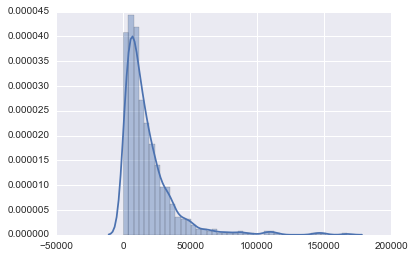

In [423]:
print("MSE: " + str( sess.run(mean_square_error,  feed_dict={x: X_test, y_:y_test}) ) )
reg_pred = sess.run(y, feed_dict={x:X_test})
scores = []
diffs = []
for i in range(len(reg_pred)):
    scores.append(ee)
    diffs.append(abs(reg_pred[i]-y_test[i]))
print("accuracy: " + str(np.mean(scores)))
print("mean real values: " + str(np.mean(y_test)))
print("mean diff: " + str(np.mean(diffs)))
print("mean diff error: " + str(np.mean(diffs) / np.mean(y_test) * 100) + "%")
sns.distplot(diffs)

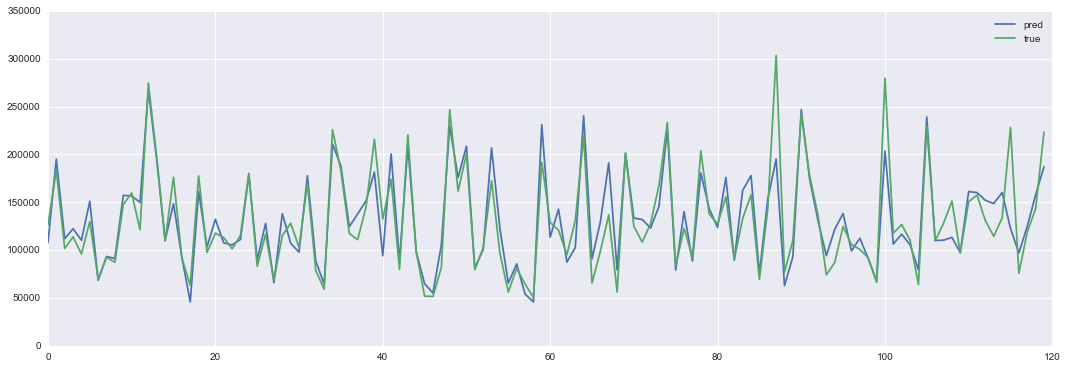

In [424]:
plt.figure(figsize=(18,6))
N = 120
plt.plot(reg_pred[:N],label='pred')
plt.plot(y_test[:N],label='true')
plt.legend()
plt.show()